In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import paired_euclidean_distances as PED
from sklearn.base import BaseEstimator, ClusterMixin

In [391]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
       center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

# Python-реализация

In [ ]:
class Kmeans(BaseEstimator, ClusterMixin): 
    def __init__(self, k=3, metric='euclidean', max_iter=1000, random_state=None):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter

    def fit(self, X, y=None):        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.zeros(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.zeros((self.k, X.shape[1]))
        
        # Среди массива имеющихся точек случайно выбираем центройды
        for i in xrange(self.k):
            self.centroids[i] = X[np.random.randint(0,X.shape[0])]
        
        # Сохраняем начальную конфигурацию центройдов
        self.centroids_init = np.copy(self.centroids)
        
        for n in xrange(self.max_iter):
            # Расчет принадлежности каждой точки к определеному кластеру
            for i in xrange(X.shape[0]):
                distances = [] 
                for centr in self.centroids:
                    distances.append(PED(centr.reshape((1,-1)), X[i].reshape((1,-1))))

                self.labels[i] = distances.index(min(distances))

            # Расчет количества точек, принадлежащих каждому кластеру
            freq_centr = np.zeros(self.k)
            for label in self.labels:
                freq_centr[int(label)] += 1

            # Расчет нового положения центройдов
            self.centroids = np.zeros(self.centroids.shape)
            for i in xrange(X.shape[0]):
                idx = int(self.labels[i])
                self.centroids[idx] += X[i] / freq_centr[idx]
                    
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        
        return self.labels
    
    
klusters = Kmeans()

In [374]:
%%timeit
klusters.fit(X,y)

1 loop, best of 3: 20.6 s per loop


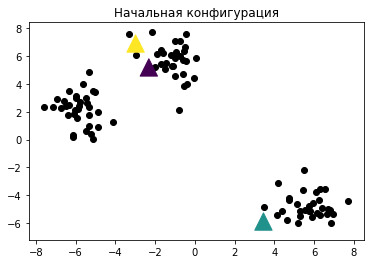

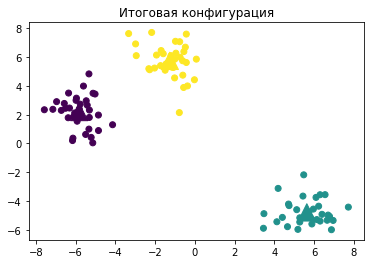

In [375]:
plt.figure()
plt.title(u'Начальная конфигурация')
plt.scatter(X[:,0], X[:, 1], c='black') 
plt.scatter(klusters.centroids_init[:,0],klusters.centroids_init[:,1], c=range(0,klusters.k), marker='^', s=300)

plt.figure()
plt.title(u'Итоговая конфигурация')
plt.scatter(X[:,0], X[:, 1],c=klusters.labels) 
plt.scatter(klusters.centroids[:,0],klusters.centroids[:,1], c=range(0,klusters.k), marker='^', s=300)

# Python-реализация с матричными операциями

In [498]:
class Kmeans(BaseEstimator, ClusterMixin): 
    def __init__(self, k=3, metric='euclidean', max_iter=1000, random_state=None):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter

    def fit(self, X, y=None):        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.zeros((1,X.shape[0]))
        
        # Массив с центройдами кластеров
        self.centroids = np.zeros((self.k, X.shape[1]))
        
        # Среди массива имеющихся точек случайно выбираем центройды
        for i in xrange(self.k):
            self.centroids[i] = X[np.random.randint(0,X.shape[0])]
        
        # Сохраняем начальную конфигурацию центройдов
        self.centroids_init = np.copy(self.centroids)
        
        for n in xrange(self.max_iter):
            res = np.sqrt((np.square(self.centroids[:,np.newaxis]-X).sum(axis=2)))
            for i in xrange(X.shape[0]):
                self.labels[0][i] = np.argmin(res[:,[i]])

            # Расчет количества точек, принадлежащих каждому кластеру
            freq_centr = np.zeros((1,self.k))
            for idx_label in xrange(X.shape[0]):
                freq_centr[0][int(self.labels[0][idx_label])] += 1

            # Расчет нового положения центройдов
            self.centroids = np.zeros(self.centroids.shape)
            for i in xrange(X.shape[0]):
                idx = int(self.labels[0][i])
                self.centroids[idx] += X[i] / freq_centr[0][idx]
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        
        return self.labels
    
    
klusters = Kmeans()

In [499]:
%%timeit
klusters.fit(X,y)

1 loop, best of 3: 1.25 s per loop


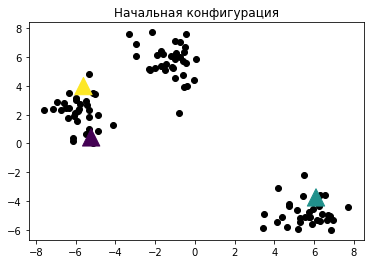

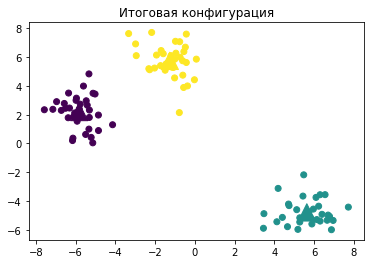

In [500]:
plt.figure()
plt.title(u'Начальная конфигурация')
plt.scatter(X[:,0], X[:, 1], c='black') 
plt.scatter(klusters.centroids_init[:,0],klusters.centroids_init[:,1], c=range(0,klusters.k), marker='^', s=300)

plt.figure()
plt.title(u'Итоговая конфигурация')
plt.scatter(X[:,0], X[:, 1],c=klusters.labels) 
plt.scatter(klusters.centroids[:,0],klusters.centroids[:,1], c=range(0,klusters.k), marker='^', s=300)

# jit-реализация

In [151]:
from numba import jit

In [396]:
@jit(nopython=True)
def jit_kmeans_fit(X, k=3, metric='euclidean', max_iter=1000, random_state=1):        
    # Инициализация генератора случайных чисел
    np.random.seed(random_state)

    # Массив с метками кластеров для каждого объекта из X
    labels = np.zeros((1,X.shape[0]))

    # Массив с центройдами кластеров
    centroids = np.zeros((k, X.shape[1]))

    # Среди массива имеющихся точек случайно выбираем центройды
    for i in xrange(centroids.shape[0]):
        centroids[i] = X[np.random.randint(0,X.shape[0])]
    
    # Сохраняем начальную конфигурацию центройдов
    centroids_init = np.copy(centroids)

    for n in xrange(max_iter):
        # Расчет принадлежности каждой точки к определеному кластеру
        for i in xrange(X.shape[0]):
            min_dist = 10**5
            min_idx = -1
            for centr_idx in xrange(centroids.shape[0]):
                dist = np.sqrt((centroids[centr_idx][0] - X[i][0])**2 + (centroids[centr_idx][1] - X[i][1])**2)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = centr_idx                   
            labels[0][i] = min_idx
    
        # Расчет количества точек, принадлежащих каждому кластеру
        freq_centr = np.zeros((1, k))
        for label_idx in xrange(labels.shape[1]):
            idx = int(labels[0][label_idx])
            freq_centr[0][idx] += 1
            
        # Расчет нового положения центройдов
        centroids = np.zeros(centroids.shape)
        for i in xrange(X.shape[0]):
            idx = int(labels[0][i])
            centroids[idx][0] += X[i][0] / freq_centr[0][idx]
            centroids[idx][1] += X[i][1] / freq_centr[0][idx]
    
    
    return (k, centroids_init, centroids, labels)

In [398]:
%%timeit
(k, centroids_init, centroids, labels) = jit_kmeans_fit(X)

100 loops, best of 3: 3.72 ms per loop


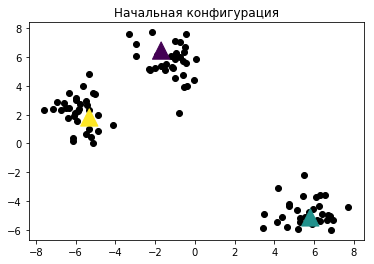

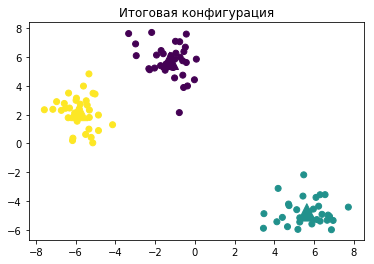

In [399]:
plt.figure()
plt.title(u'Начальная конфигурация')
plt.scatter(X[:,0], X[:, 1], c='black') 
plt.scatter(centroids_init[:,0], centroids_init[:,1], c=range(k), marker='^', s=300)

plt.figure()
plt.title(u'Итоговая конфигурация')
plt.scatter(X[:,0], X[:, 1],c=labels) 
plt.scatter(centroids[:,0], centroids[:,1], c=range(0,k), marker='^', s=300)

# Cython-реализация

In [388]:
%reload_ext Cython

In [427]:
%%cython -a
import numpy as cnp
cimport numpy as cnp

cpdef cython_kmeans_fit(cnp.ndarray[cnp.float64_t, ndim=2] X, int k=3, int max_iter=1000):            
    cdef int n_objects, n_features
    n_objects, n_features = X.shape[0], X.shape[1]
    
    # Массив с метками кластеров для каждого объекта из X
    cdef cnp.ndarray[cnp.float64_t, ndim=1] labels = cnp.zeros(n_objects)

    # Массив с центройдами кластеров
    cdef cnp.ndarray[cnp.float64_t, ndim=2] centroids = cnp.zeros((k, n_features))
    
    # Среди массива имеющихся точек случайно выбираем центройды
    for i in xrange(k):
        centroids[i] = X[cnp.random.randint(0,n_objects)]
    
    # Сохраняем начальную конфигурацию центройдов
    cdef cnp.ndarray[cnp.float64_t, ndim=2] centroids_init = cnp.copy(centroids)
    
    for n in xrange(max_iter):
        # Расчет принадлежности каждой точки к определеному кластеру
        for i in xrange(n_objects):
            min_dist = 10**5
            min_idx = -1
            for centr_idx in xrange(k):
                dist = cnp.sqrt((centroids[centr_idx][0] - X[i][0])**2 + (centroids[centr_idx][1] - X[i][1])**2)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = centr_idx                   
            labels[i] = min_idx
    
        # Расчет количества точек, принадлежащих каждому кластеру
        freq_centr = cnp.zeros(k)
        for label_idx in xrange(n_objects):
            idx = int(labels[label_idx])
            freq_centr[idx] += 1
            
        # Расчет нового положения центройдов
        centroids = cnp.zeros((k,n_objects))
        for i in xrange(n_objects):
            idx = int(labels[i])
            centroids[idx][0] += X[i][0] / freq_centr[idx]
            centroids[idx][1] += X[i][1] / freq_centr[idx]
    
    
    return (k, centroids_init, centroids, labels)

In [428]:
%%timeit
(k, centroids_init, centroids, labels) = cython_kmeans_fit(X)

1 loop, best of 3: 1.08 s per loop


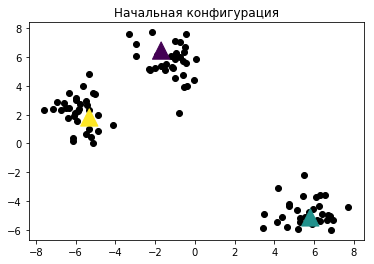

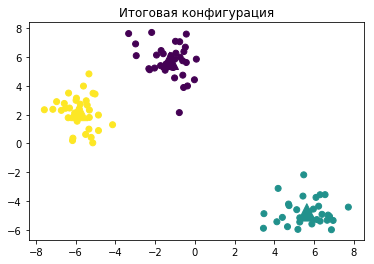

In [429]:
plt.figure()
plt.title(u'Начальная конфигурация')
plt.scatter(X[:,0], X[:, 1], c='black') 
plt.scatter(centroids_init[:,0], centroids_init[:,1], c=range(k), marker='^', s=300)

plt.figure()
plt.title(u'Итоговая конфигурация')
plt.scatter(X[:,0], X[:, 1],c=labels) 
plt.scatter(centroids[:,0], centroids[:,1], c=range(0,k), marker='^', s=300)

# ВЫВОДЫ

После реализаций k-means разными способами можно составить список их быстродействия по убывающей:
1. jit
2. Cython
3. Python с матричными операциями
4. Python

Алгоритмы с использованием jit и Cython'a имеют самое высокое быстродействие в связи с тем, что в них происходит компиляция в машинный код. Матричная реализация,  используя непрерывные участки памяти вместо произвольных в случае обычной python-реализации, имеет ускоренный доступ к ячейкам памяти и, следовательно, лучшую скорость работы.

Python-реализация с матричными операциями вряд ли может работать быстрее, посколько единственная операция, которую можно было заменить на матричную, была заменена. Остальные операции без циклов обойтись не могут.

Cython-реализация также вряд ли может работать быстрее, поскольку число строк желтого цвета, означающих взаимодействие с Python, было сведено к минимуму.